In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import asc, col, isnan, when, count, median, udf, concat, month, year, substring, lit, desc
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import os
import duckdb
import pyarrow
import pandas as pd

In [2]:
conn = duckdb.connect('data_ana.db')

conf = SparkConf() \
    .setAppName("data_ana") \
    .set("spark.driver.memory", "12g")\
    .set("spark.executor.cores","8") \
    .set("spark.sql.execution.arrow.pyspark.enabled","true")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/20 08:57:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
csv_file_path ="/workspace/data.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
df.orderBy(asc("fecha_dato"))

DataFrame[fecha_dato: date, ncodpers: double, ind_empleado: string, pais_residencia: string, sexo: string, age: string, fecha_alta: date, ind_nuevo: string, antiguedad: string, indrel: string, ult_fec_cli_1t: date, indrel_1mes: string, tiprel_1mes: string, indresi: string, indext: string, conyuemp: string, canal_entrada: string, indfall: string, tipodom: string, cod_prov: string, nomprov: string, ind_actividad_cliente: string, renta: double, segmento: string, ind_ahor_fin_ult1: int, ind_aval_fin_ult1: int, ind_cco_fin_ult1: int, ind_cder_fin_ult1: int, ind_cno_fin_ult1: int, ind_ctju_fin_ult1: int, ind_ctma_fin_ult1: int, ind_ctop_fin_ult1: int, ind_ctpp_fin_ult1: int, ind_deco_fin_ult1: int, ind_deme_fin_ult1: int, ind_dela_fin_ult1: int, ind_ecue_fin_ult1: int, ind_fond_fin_ult1: int, ind_hip_fin_ult1: int, ind_plan_fin_ult1: int, ind_pres_fin_ult1: int, ind_reca_fin_ult1: int, ind_tjcr_fin_ult1: int, ind_valo_fin_ult1: int, ind_viv_fin_ult1: int, ind_nomina_ult1: string, ind_nom_pen

In [4]:
df = df.withColumn("ncodpers", df["ncodpers"].cast(IntegerType()))
df = df.withColumn("ind_nomina_ult1", df["ind_nomina_ult1"].cast(IntegerType()))
df = df.withColumn("ind_nom_pens_ult1", df["ind_nom_pens_ult1"].cast(IntegerType()))

In [5]:
feature_list = [ "ind_ahor_fin_ult1",
    "ind_aval_fin_ult1",
    "ind_cco_fin_ult1",
    "ind_cder_fin_ult1",
    "ind_cno_fin_ult1",
    "ind_ctju_fin_ult1",
    "ind_ctma_fin_ult1",
    "ind_ctop_fin_ult1",
    "ind_ctpp_fin_ult1",
    "ind_deco_fin_ult1",
    "ind_deme_fin_ult1",
    "ind_dela_fin_ult1",
    "ind_ecue_fin_ult1",
    "ind_fond_fin_ult1",
    "ind_hip_fin_ult1",
    "ind_plan_fin_ult1",
    "ind_pres_fin_ult1",
    "ind_reca_fin_ult1",
    "ind_tjcr_fin_ult1",
    "ind_valo_fin_ult1",
    "ind_viv_fin_ult1",
    "ind_nomina_ult1",
    "ind_nom_pens_ult1",
    "ind_recibo_ult1"]

feature_cols = [F.col(col) for col in feature_list]
features_array = F.array(*feature_cols).alias("features")

grouped_df = df.select("ncodpers", *feature_list).withColumn("features", features_array) \
    .groupBy("ncodpers") \
    .agg(F.collect_list("features").alias("features_list"))

customer_feature = {row["ncodpers"]: row["features_list"] for row in grouped_df.collect()}
counts = {feature: 0 for feature in feature_list}

for features in customer_feature.values():
    for feat_array in features:
        for idx, val in enumerate(feat_array):
            counts[feature_list[idx]] += 1 if val == 1 else 0

In [6]:
feature_occur_times = spark.createDataFrame(list(counts.items()), ["feature", "count"])

In [8]:
df = df.withColumn("fecha_dato", F.to_date("fecha_dato", "yyyy-MM-dd"))

# Assume the first 24 columns are metadata; the remaining columns are target product indicators
all_columns = df.columns
target_cols = all_columns[24:]

# Define a window partitioned by customer (ncodpers) ordered by date
w = Window.partitionBy("ncodpers").orderBy("fecha_dato")

# Compute lag of fecha_dato and each target column for each customer
df = df.withColumn("prev_fecha", F.lag("fecha_dato").over(w))
for col in target_cols:
    df = df.withColumn(f"prev_{col}", F.lag(col).over(w))

# For each target product column, flag rows that become 1 from a previous 0
# and where the date difference is less than 32 days
for col in target_cols:
    df = df.withColumn(f"{col}_new",
        F.when(
            (F.col(f"prev_{col}") == 0) & 
            (F.col(col) == 1) & 
            (F.datediff(F.col("fecha_dato"), F.col("prev_fecha")) < 32),
            1
        ).otherwise(0)
    )

# Now, aggregate by fecha_dato to obtain the monthly new product counts
agg_exprs = [F.sum(f"{col}_new").alias(col) for col in target_cols]
monthly_new_counts = df.groupBy("fecha_dato").agg(*agg_exprs).orderBy("fecha_dato")

monthly_new_counts.show()

25/02/19 15:19:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+---------------+-----------------+---------------+
|fecha_dato|ind_ahor_fin_ult1|ind_aval_fin_ult1|ind_cco_fin_ult1|ind_cder_fin_ult1|ind_cno_fin_ult1|ind_ctju_fin_ult1|ind_ctma_fin_ult1|ind_ctop_fin_ult1|ind_ctpp_fin_ult1|ind_deco_fin_ult1|ind_deme_fin_ult1|ind_dela_fin_ult1|ind_ecue_fin_ult1|ind_fond_fin_ult1|ind_hip_fin_ult1|ind_plan_fin_ult1|ind_pres_fin_ult1|ind_reca_fin_ult1|ind_tjcr_fin_ult1|ind_valo_fin_ult1|ind_viv_fin_ult1|ind_nomina_ult1|ind_nom_pens_ult1|ind_recibo_ult1|
+----------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+--------

In [10]:
    # Create lagged fecha_dato
    #df = df.withColumn("prev_fecha", F.lag("fecha_dato").over(w))

    # Create lagged target columns for each product
    for col in target_cols:
        df = df.withColumn(f"prev_{col}", F.lag(col).over(w))

    # For each target product column, flag rows where the product is dropped:
    # (transition from 1 to 0) with days difference < 32.
    for col in target_cols:
        df = df.withColumn(f"{col}_left",
             F.when(
                (F.col(f"prev_{col}") == 1) & 
                (F.col(col) == 0) & 
                (F.datediff(F.col("fecha_dato"), F.col("prev_fecha")) < 32),
                1
             ).otherwise(0)
         )
    
    # Aggregate by fecha_dato to obtain the monthly user leave counts for each product
    agg_exprs = [F.sum(f"{col}_left").alias(col) for col in target_cols]
    monthly_leave_counts = df.groupBy("fecha_dato").agg(*agg_exprs).orderBy("fecha_dato")
    
    monthly_leave_counts.show()

+----------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+---------------+-----------------+---------------+
|fecha_dato|ind_ahor_fin_ult1|ind_aval_fin_ult1|ind_cco_fin_ult1|ind_cder_fin_ult1|ind_cno_fin_ult1|ind_ctju_fin_ult1|ind_ctma_fin_ult1|ind_ctop_fin_ult1|ind_ctpp_fin_ult1|ind_deco_fin_ult1|ind_deme_fin_ult1|ind_dela_fin_ult1|ind_ecue_fin_ult1|ind_fond_fin_ult1|ind_hip_fin_ult1|ind_plan_fin_ult1|ind_pres_fin_ult1|ind_reca_fin_ult1|ind_tjcr_fin_ult1|ind_valo_fin_ult1|ind_viv_fin_ult1|ind_nomina_ult1|ind_nom_pens_ult1|ind_recibo_ult1|
+----------+-----------------+-----------------+----------------+-----------------+----------------+-----------------+--------

In [12]:
total_counts = df.groupBy("ncodpers").agg(F.count("*").alias("total_count"))
total_counts.show()

# Count distinct months a customer appears in (assuming fecha_dato represents the month)
distinct_month_counts = df.groupBy("ncodpers").agg(F.countDistinct("fecha_dato").alias("month_count"))
distinct_month_counts.show()

+--------+-----------+
|ncodpers|total_count|
+--------+-----------+
| 1050607|         17|
| 1050426|         17|
| 1051867|         17|
| 1051742|         17|
| 1051547|         17|
| 1051451|         17|
| 1048661|         17|
| 1048726|         17|
| 1049332|         17|
| 1049636|         17|
| 1055946|         17|
| 1056289|         17|
| 1056442|         17|
| 1056379|         17|
| 1053078|         17|
| 1053660|         17|
| 1055076|         17|
| 1053861|         17|
| 1054452|         17|
| 1044242|         17|
+--------+-----------+
only showing top 20 rows



+--------+-----------+
|ncodpers|month_count|
+--------+-----------+
| 1050426|         17|
| 1046377|         17|
| 1119124|         17|
| 1092727|         17|
|  921353|         17|
| 1279760|         17|
| 1357617|         17|
| 1326869|         17|
| 1219766|         17|
|  292608|         17|
|  386998|         17|
|  404885|         17|
|   88674|         17|
|  114503|         17|
|   41575|         17|
|   27974|         17|
|  196013|         17|
|  120899|         17|
|  560682|         17|
|  515751|         17|
+--------+-----------+
only showing top 20 rows



In [14]:
month_counts = df.groupBy("ncodpers").agg(
    F.countDistinct("fecha_dato").alias("month_count")
)

num_customers_lt_17 = month_counts.filter(F.col("month_count") < 17).count()
num_customers_lt_17

351181

In [15]:
# Create a new column for month from fecha_dato if not already defined
# df = df.withColumn("month_int", F.month("fecha_dato"))
# Get distinct customer-month combinations
customer_month = df.select("ncodpers", "fecha_dato").distinct()

# Pivot the DataFrame so that each customer becomes a row and each month becomes a column.
# Customers get a 1 if they appear in that month.
customer_appear_month = customer_month.groupBy("ncodpers") \
    .pivot("fecha_dato") \
    .agg(F.lit(1)) \
    .fillna(0)

customer_appear_month.orderBy(asc("ncodpers")).show()

+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|ncodpers|2015-01-28|2015-02-28|2015-03-28|2015-04-28|2015-05-28|2015-06-28|2015-07-28|2015-08-28|2015-09-28|2015-10-28|2015-11-28|2015-12-28|2016-01-28|2016-02-28|2016-03-28|2016-04-28|2016-05-28|
+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|   15889|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|
|   15890|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|         1|
|   15891|

In [ ]:
# customer_month.orderBy(asc("ncodpers"),asc("fecha_dato")).show(6)

+--------+----------+
|ncodpers|fecha_dato|
+--------+----------+
|   15889|2015-01-28|
|   15889|2015-02-28|
|   15889|2015-03-28|
|   15889|2015-04-28|
|   15889|2015-05-28|
|   15889|2015-06-28|
+--------+----------+
only showing top 6 rows



In [17]:
first_appearance = df.groupBy("ncodpers").agg(F.min("fecha_dato"))
first_appearance.show(5)

+--------+---------------+
|ncodpers|min(fecha_dato)|
+--------+---------------+
| 1050607|     2015-01-28|
| 1050426|     2015-01-28|
| 1051867|     2015-01-28|
| 1051742|     2015-01-28|
| 1051547|     2015-01-28|
+--------+---------------+
only showing top 5 rows



In [19]:
avg_renta = df.select("nomprov","renta").distinct().filter(F.col("nomprov").isNotNull())

avg_renta = avg_renta.groupBy("nomprov").agg(F.round(F.avg("renta"),2).alias("avg_renta"))
avg_renta.orderBy(desc("avg_renta")).show(5)

+--------------+---------+
|       nomprov|avg_renta|
+--------------+---------+
|         CEUTA|177170.26|
|        MADRID| 169664.0|
|     BARCELONA| 161445.8|
|BALEARS, ILLES|161428.15|
|        GIRONA|146254.43|
+--------------+---------+
only showing top 5 rows



In [ ]:
first_appearance = first_appearance.toPandas()
conn.sql("CREATE TABLE first_appearance AS SELECT * FROM first_appearance")

In [20]:
avg_renta = avg_renta.toPandas()
conn.sql("CREATE TABLE avg_renta AS SELECT * FROM avg_renta")

In [ ]:
feature_occur_times = feature_occur_times.toPandas()
conn.sql("CREATE TABLE feature_occur_times AS SELECT * FROM feature_occur_times")

CatalogException: Catalog Error: Table with name "feature_occur_times" already exists!

In [ ]:
customer_appear_month = customer_appear_month.toPandas()
conn.sql("CREATE TABLE customer_appear_month AS SELECT * FROM customer_appear_month")

In [ ]:
monthly_leave_counts = monthly_leave_counts.toPandas()
conn.sql("CREATE TABLE monthly_leave_counts AS SELECT * FROM monthly_leave_counts")

In [ ]:
monthly_new_counts = monthly_new_counts.toPandas()
conn.sql("CREATE TABLE monthly_new_counts AS SELECT * FROM monthly_new_counts")

In [ ]:
total_counts = total_counts.toPandas()
conn.sql("CREATE TABLE total_counts AS SELECT * FROM total_counts")

distinct_month_counts = distinct_month_counts.toPandas()
conn.sql("CREATE TABLE distinct_month_counts AS SELECT * FROM distinct_month_counts")

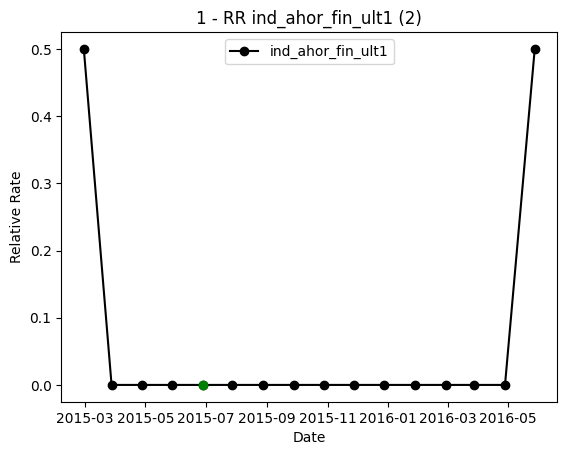

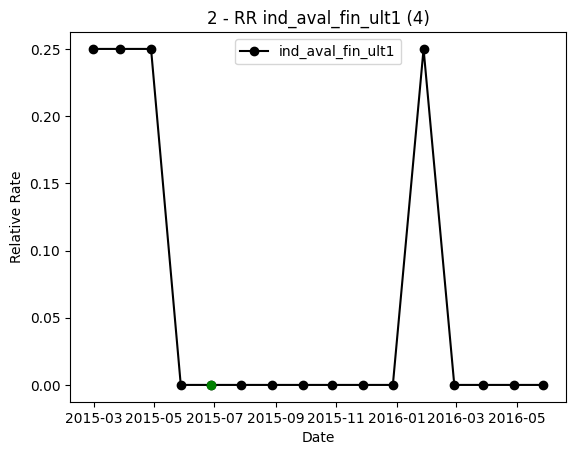

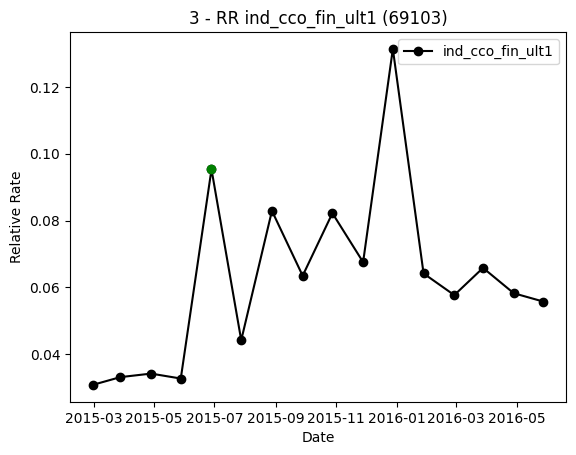

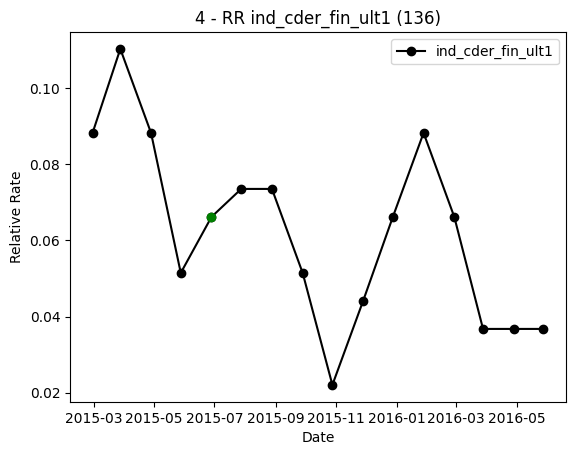

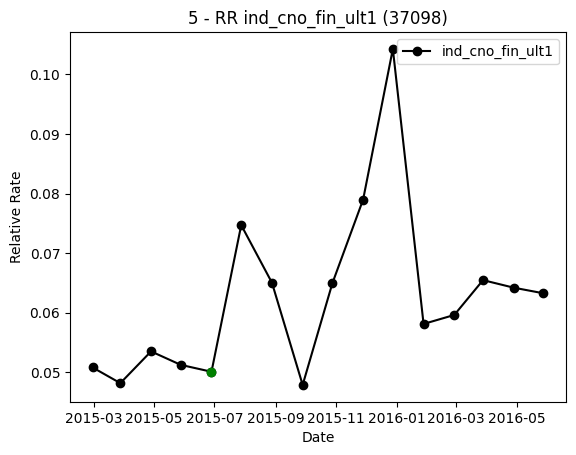

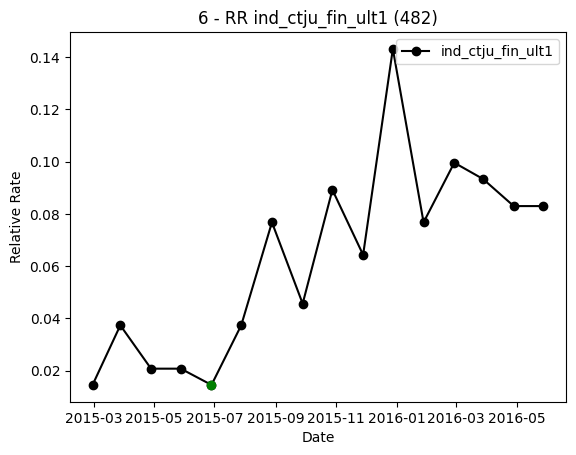

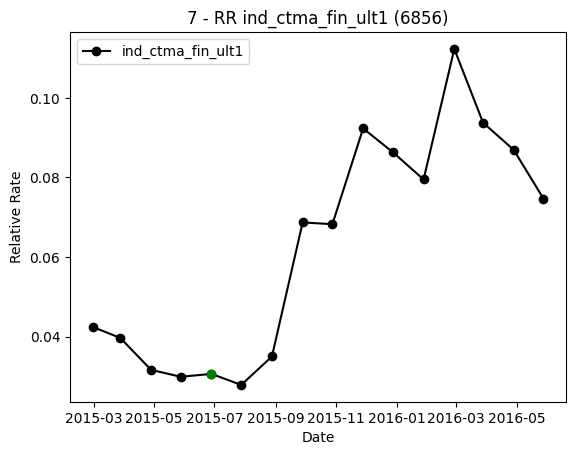

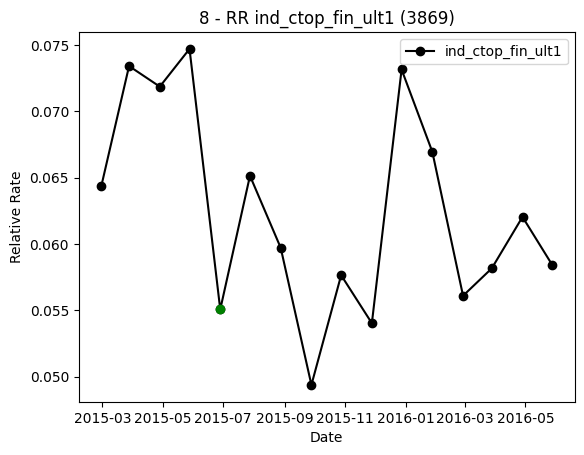

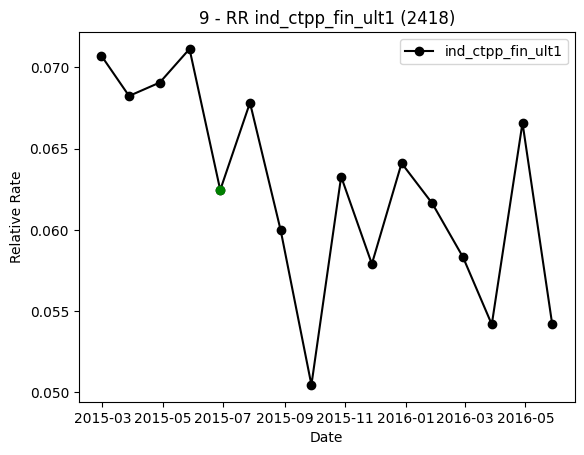

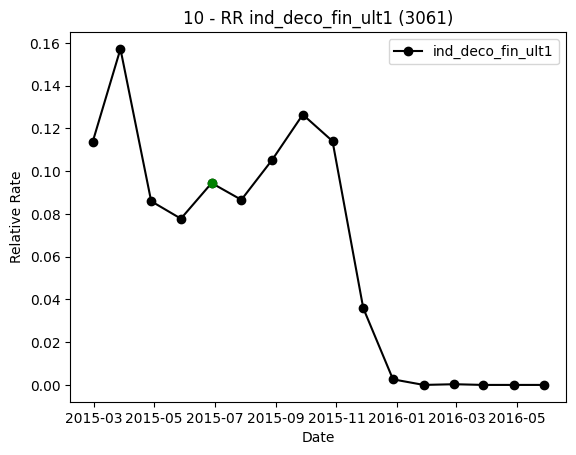

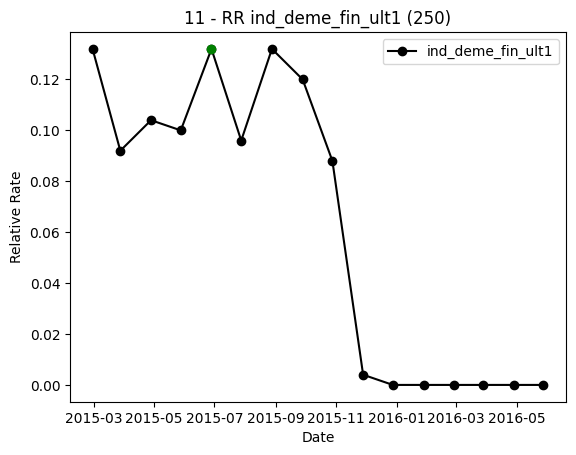

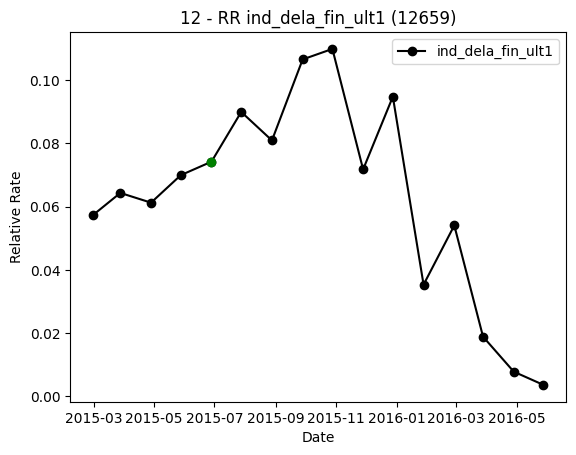

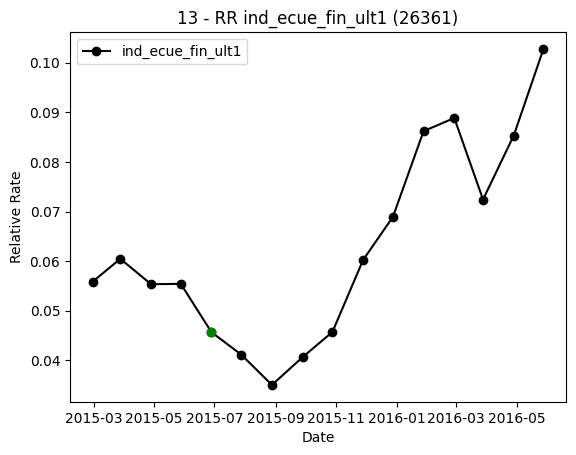

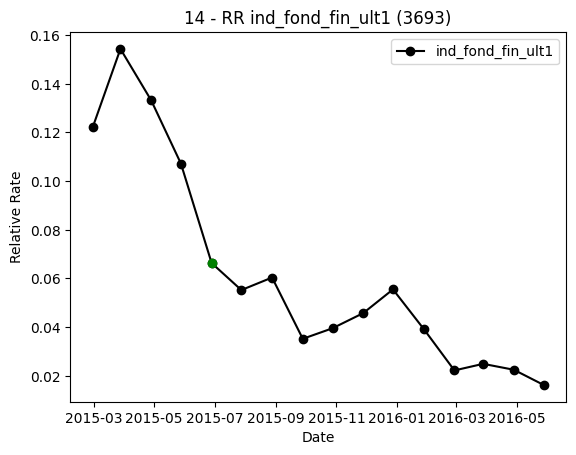

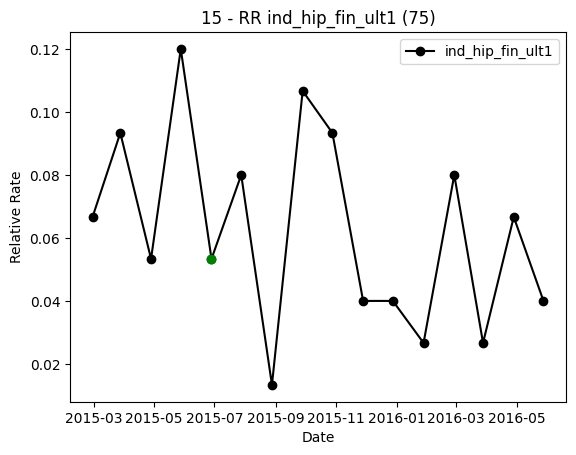

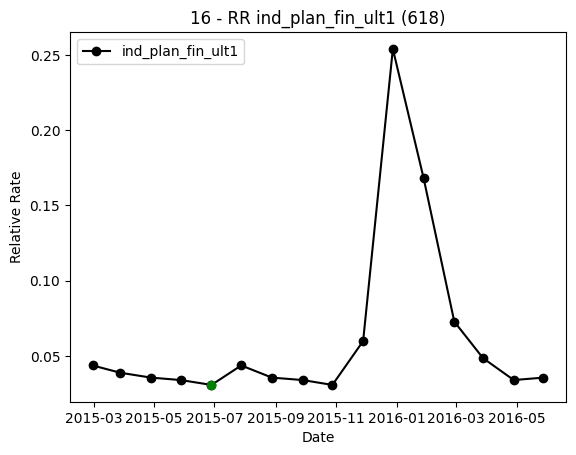

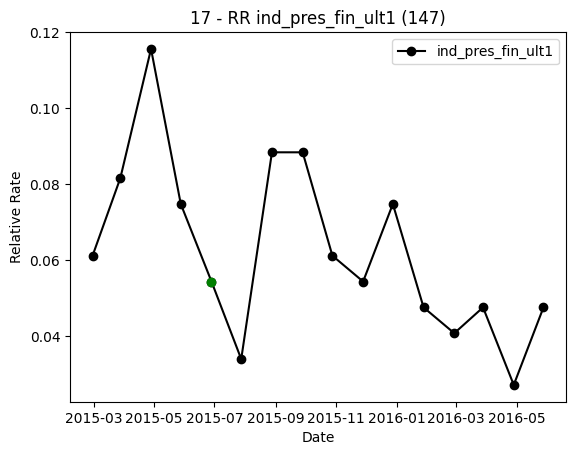

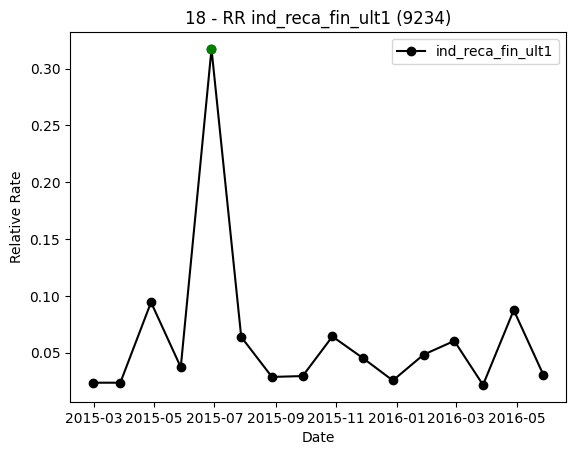

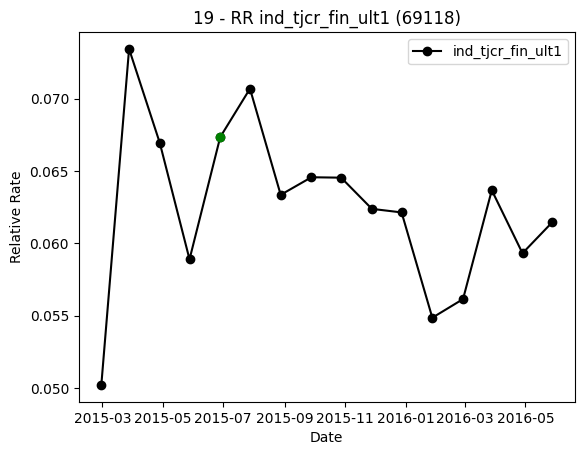

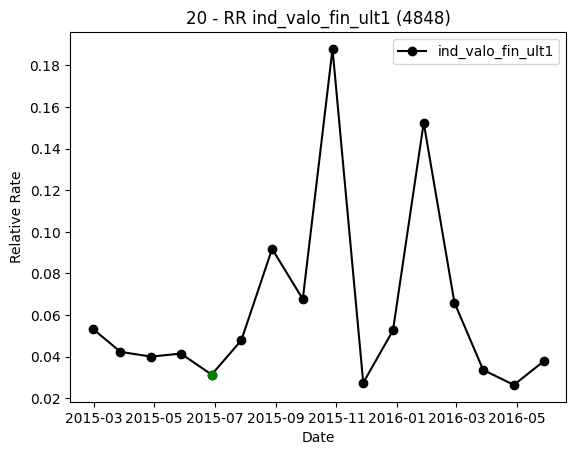

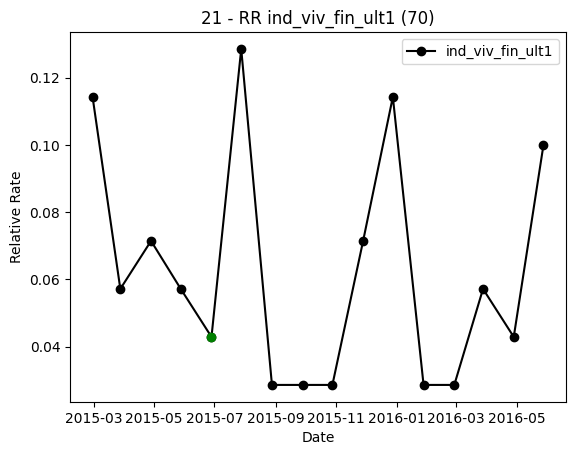

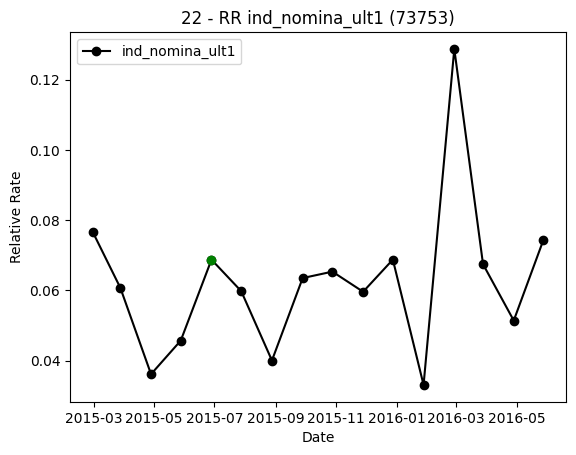

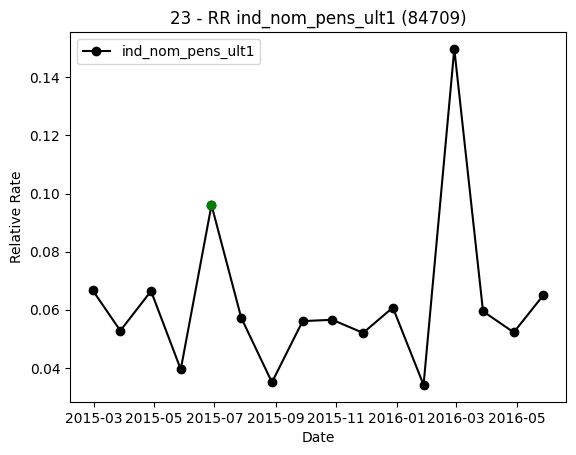

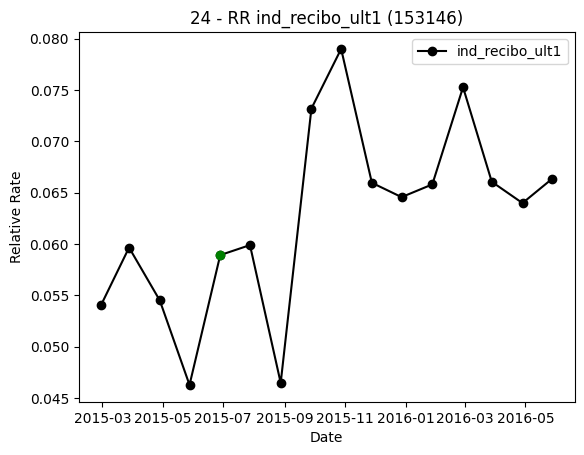

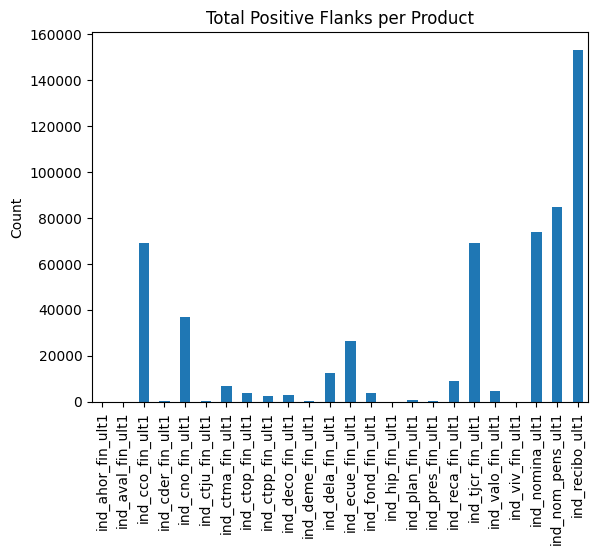

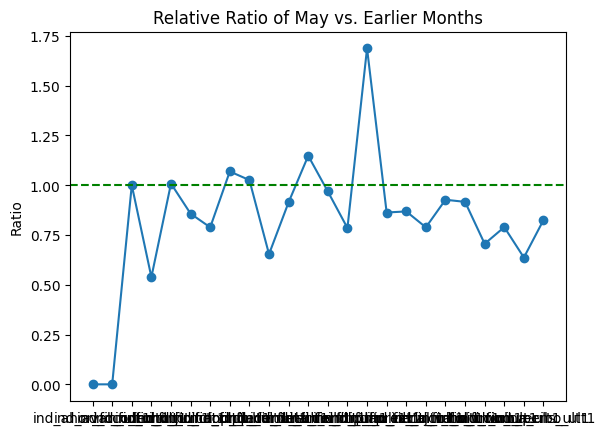

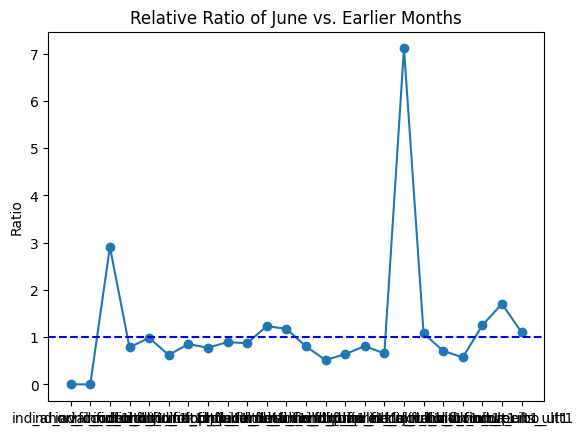

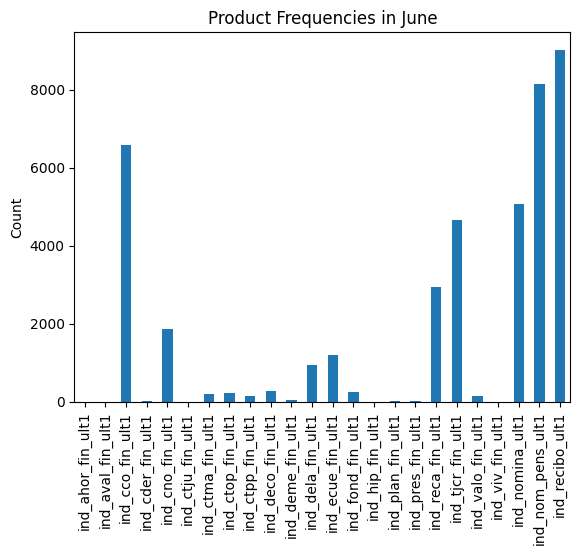

In [4]:
# Language: Python (PySpark)
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Ensure fecha_dato is in date format
df = df.withColumn("fecha_dato", F.to_date("fecha_dato", "yyyy-MM-dd"))

# Define target product columns (all columns from index 24 onward)
targetCols = df.columns[24:]
nbTargetCols = len(targetCols)

# Get sorted unique dates (skip the first one as in the R code)
sorted_dates = [r.fecha_dato for r in df.select("fecha_dato").distinct().orderBy("fecha_dato").collect()][1:]
nbDates = len(sorted_dates)

# Create a window partitioned by client (ncodpers) ordered by fecha_dato
w = Window.partitionBy("ncodpers").orderBy("fecha_dato")

# Add lag columns: lag_fecha and for each product the lag value
df = df.withColumn("lag_fecha", F.lag("fecha_dato").over(w))
for t in targetCols:
    df = df.withColumn(f"lag_{t}", F.lag(F.col(t)).over(w))

# For each product, flag positive flank occurrences:
# Condition: for a given product, previous value equals 0 and current equals 1,
# and the difference in fecha_dato is less than 32 days.
all_counts = {}
for t in targetCols:
    pos_cond = (F.col(t) == 1) & (F.col(f"lag_{t}") == 0) & (F.datediff(F.col("fecha_dato"), F.col("lag_fecha")) < 32)
    df_flag = df.withColumn("positive_flank", F.when(pos_cond, 1).otherwise(0))
    
    # Group by fecha_dato and count positive flanks for this product
    prod_counts = df_flag.groupBy("fecha_dato").agg(F.sum("positive_flank").alias("count"))
    # Convert to Pandas, ensure the index covers all sorted_dates (missing dates -> 0)
    prod_pd = prod_counts.toPandas()
    prod_pd['fecha_dato'] = pd.to_datetime(prod_pd['fecha_dato'])
    prod_pd = prod_pd.set_index('fecha_dato').reindex(sorted_dates, fill_value=0)
    all_counts[t] = prod_pd['count']

# Combine all product counts into a DataFrame (rows: months, columns: products)
allCounts_pdf = pd.DataFrame(all_counts, index=sorted_dates)

# ----- Plot relative monthly fractions for each product -----
for i, t in enumerate(targetCols):
    counts = allCounts_pdf[t]
    frac = counts / counts.sum() if counts.sum() != 0 else counts
    plt.figure()
    plt.plot(sorted_dates, frac, marker='o', color='black', label=t)
    if len(sorted_dates) >= 5:
        plt.plot(sorted_dates[4], frac.iloc[4], marker='o', color='green')
    plt.title(f"{i+1} - RR {t} ({counts.sum()})")
    plt.xlabel("Date")
    plt.ylabel("Relative Rate")
    plt.legend()
    plt.show()
    plt.pause(2)

# ----- Overall Influence: Compute row-wise fractions -----
row_sums = allCounts_pdf.sum(axis=1)
overall_frac = allCounts_pdf.divide(row_sums, axis=0)

# ----- Relative Ratios Calculation -----
# For June (5th row: index 4) vs. first four months (rows 0 to 3)
if allCounts_pdf.shape[0] >= 5:
    relativeRatiosJune = allCounts_pdf.iloc[4] / allCounts_pdf.iloc[:4].mean(axis=0)
else:
    relativeRatiosJune = pd.Series(0, index=targetCols)

# For May (4th row: index 3) vs. first three months (rows 0 to 2)
if allCounts_pdf.shape[0] >= 4:
    relativeRatiosMay = allCounts_pdf.iloc[3] / allCounts_pdf.iloc[:3].mean(axis=0)
else:
    relativeRatiosMay = pd.Series(0, index=targetCols)

# ----- Plotting -----
# Total positive flanks per product
nbPosFlanks = allCounts_pdf.sum(axis=0)
plt.figure()
nbPosFlanks.plot(kind="bar")
plt.title("Total Positive Flanks per Product")
plt.ylabel("Count")
plt.show()

# Relative ratio of May versus earlier months
plt.figure()
plt.plot(relativeRatiosMay, marker='o')
plt.axhline(y=1, color="green", linestyle="--")
plt.title("Relative Ratio of May vs. Earlier Months")
plt.ylabel("Ratio")
plt.show()

# Relative ratio of June versus earlier months
plt.figure()
plt.plot(relativeRatiosJune, marker='o')
plt.axhline(y=1, color="blue", linestyle="--")
plt.title("Relative Ratio of June vs. Earlier Months")
plt.ylabel("Ratio")
plt.show()

# Product frequencies in June (5th month)
if allCounts_pdf.shape[0] >= 5:
    juneCounts = allCounts_pdf.iloc[4]
    plt.figure()
    juneCounts.plot(kind="bar")
    plt.title("Product Frequencies in June")
    plt.ylabel("Count")
    plt.show()